Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       758
           1       0.50      0.41      0.45       243

    accuracy                           0.76      1001
   macro avg       0.66      0.64      0.65      1001
weighted avg       0.74      0.76      0.75      1001

ROC AUC: 0.7170483294787018


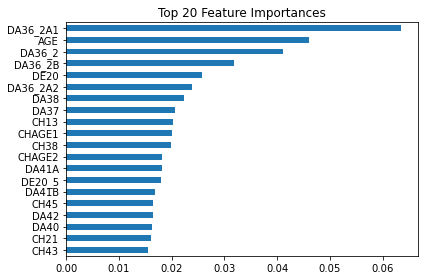

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv("35067-0001-Data.tsv", sep='\t')
df = df[df["DSM_ALA"].isin([1, 5])].copy()
df["DSM_ALA_BINARY"] = df["DSM_ALA"].replace({5: 0, 1: 1})
prefixes = ['CH', 'DA', 'DE']
demographic_cols = ['AGE', 'SEX', 'MARITAL', 'EDUC', 'EMPSTAT', 'INCOME']
core_features = [col for col in df.columns if any(col.startswith(p) for p in prefixes)]
available_demos = [col for col in demographic_cols if col in df.columns]
features = core_features + available_demos

X = df[features]
y = df["DSM_ALA_BINARY"]

# Impute with most frequent
X_imputed = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Oversample minority class
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data["DSM_ALA_BINARY"] == 0]
minority = train_data[train_data["DSM_ALA_BINARY"] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
balanced = pd.concat([majority, minority_upsampled])
X_bal = balanced.drop("DSM_ALA_BINARY", axis=1)
y_bal = balanced["DSM_ALA_BINARY"]

# Grid search on Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_bal, y_bal)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# Feature importances
importances = pd.Series(best_model.feature_importances_, index=X_bal.columns).sort_values(ascending=False).head(20)
importances.plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
